# Download


In [1]:
!gdown --id 1-bS1dYxHnq0XbQXWHlmGnOfK64n_Od7g

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-bS1dYxHnq0XbQXWHlmGnOfK64n_Od7g
To: /content/intel.zip
100% 363M/363M [00:06<00:00, 52.1MB/s]


In [2]:
!unzip intel.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating: seg_tra

# Import

In [3]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.metrics import f1_score
import torch.optim as optim
from torchvision.models import ResNet
from torchvision.models.resnet import Bottleneck, BasicBlock
import torch.utils.model_zoo as model_zoo
import logging
%matplotlib inline

# Load data

In [4]:
# Data augmentation
stats = ((0.4951, 0.4982, 0.4979), (0.2482, 0.2467, 0.2807))
train_transform = tt.Compose([
    tt.Resize(112),
    tt.RandomCrop(112),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(112),
    tt.RandomCrop(112),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [5]:
train = ImageFolder("../content/seg_train/seg_train", transform = train_transform)
test = ImageFolder("../content/seg_test/seg_test",transform = test_transform)

In [6]:
torch.manual_seed(23);

In [7]:
train_loader = DataLoader(train, 32, shuffle=True, num_workers=2)
test_loader = DataLoader(test, 32, shuffle=True, num_workers=2)

In [8]:
images, labels = next(iter(train_loader)) 
print("images-size:", images.shape)

images-size: torch.Size([32, 3, 112, 112])


# Helper functions

In [9]:
def train(model, data_loader, epoch, criterion, optimizer):
  model.train()
  print(f'Epoch {epoch}\n')
  running_loss = 0
  correct = 0
  total = 0
  f1 = 0
  total_step = len(data_loader)
  for batch_idx, (data_, target_) in enumerate(data_loader):
      data_, target_ = data_.to(device), target_.to(device)
      optimizer.zero_grad()
      
      outputs = model(data_)
      loss = criterion(outputs, target_)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _,pred = torch.max(outputs, dim=1)
      correct += torch.sum(pred==target_).item()
      total += target_.size(0)
      f1 += f1_score(target_.cpu(), pred.cpu(), average="weighted")
      if (batch_idx) % 20 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
  train_acc = (100 * correct / total)
  train_loss = (running_loss/total_step)
  train_f1 = f1/total_step
  print(f'\ntrain-loss: {train_loss:.4f}, train-acc: {train_acc:.4f}, train-f1:  {train_f1:.4f}')
  return train_acc, train_loss, train_f1

def eval(model, data_loader, epoch, criterion):
  batch_loss = 0
  total_t=0
  correct_t=0
  f1_t=0
  total_step_t = len(data_loader)
  with torch.no_grad():
      model.eval()
      for data_t, target_t in (data_loader):
          data_t, target_t = data_t.to(device), target_t.to(device)
          outputs_t = model(data_t)
          loss_t = criterion(outputs_t, target_t)
          batch_loss += loss_t.item()
          _,pred_t = torch.max(outputs_t, dim=1)
          correct_t += torch.sum(pred_t==target_t).item()
          total_t += target_t.size(0)
          f1_t += f1_score(target_t.cpu(), pred_t.cpu(), average="weighted")
      val_acc = (100 * correct_t/total_t)
      val_loss = (batch_loss/len(test_loader))
      val_f1 = f1_t/total_step_t
      print(f'validation loss: {val_loss:.4f}, validation acc: {val_acc:.4f}\n, validation-f1:  {val_f1:.4f}')
  return val_acc, val_loss, val_f1

# ResNet-18

In [ ]:
device = torch.device('cuda')
num_classes = 6
model_resnet18 = torchvision.models.resnet18(pretrained=True)
# Define FC
model_resnet18.fc = nn.Linear(512, num_classes)
child_counter = 0
# for child in model_resnet18.children():
#    print(" child", child_counter, "is:")
#    print(child)
#    child_counter += 1
# cc = 0

# Freeze all layers
for child in model_resnet18.children():
  cc += 1
  if cc < 9:
    for param in child.parameters():
          param.requires_grad = False
model_resnet18.to(device)
criterion_resnet18 = nn.CrossEntropyLoss().to(device)
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.0001)
pytorch_total_params = sum(p.numel() for p in model_resnet18.parameters() if p.requires_grad)
print(pytorch_total_params)

In [13]:
n_epochs = 20
val_losses = []
val_accs = []
val_f1s = []
train_losses = []
train_accs = []
train_f1s = []
best_epoch = 0
best_acc = 0.00
for epoch in range(1, n_epochs+1):
    train_acc, train_loss, train_f1 = train(model_resnet18, train_loader, epoch, criterion_resnet18, optimizer_resnet18)
    val_acc, val_loss, val_f1 = eval(model_resnet18, test_loader, epoch, criterion_resnet18)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    if val_acc > best_acc:
      best_epoch = epoch
      best_acc = val_acc
      torch.save(model_resnet18.state_dict(), 'resnet.pt')
print(f'Best epoch: {best_epoch}, accuracy: {best_acc}')

Epoch 1

Epoch [1/20], Step [0/439], Loss: 1.9454
Epoch [1/20], Step [20/439], Loss: 1.8398
Epoch [1/20], Step [40/439], Loss: 1.7934
Epoch [1/20], Step [60/439], Loss: 1.7560
Epoch [1/20], Step [80/439], Loss: 1.6195
Epoch [1/20], Step [100/439], Loss: 1.6107
Epoch [1/20], Step [120/439], Loss: 1.5519
Epoch [1/20], Step [140/439], Loss: 1.3959
Epoch [1/20], Step [160/439], Loss: 1.3919
Epoch [1/20], Step [180/439], Loss: 1.3481
Epoch [1/20], Step [200/439], Loss: 1.3019
Epoch [1/20], Step [220/439], Loss: 1.2895
Epoch [1/20], Step [240/439], Loss: 1.1235
Epoch [1/20], Step [260/439], Loss: 1.3183
Epoch [1/20], Step [280/439], Loss: 1.2593
Epoch [1/20], Step [300/439], Loss: 1.0589
Epoch [1/20], Step [320/439], Loss: 0.9295
Epoch [1/20], Step [340/439], Loss: 1.0285
Epoch [1/20], Step [360/439], Loss: 0.9997
Epoch [1/20], Step [380/439], Loss: 0.9698
Epoch [1/20], Step [400/439], Loss: 0.9893
Epoch [1/20], Step [420/439], Loss: 0.9030

train-loss: 1.3151, train-acc: 53.6910, train-f1: 

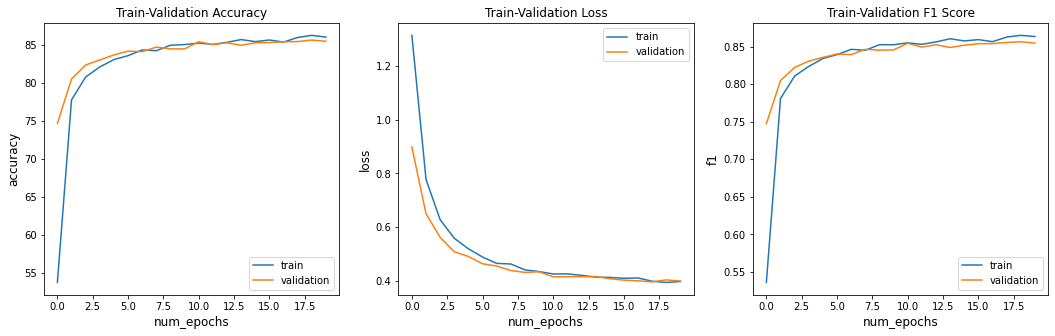

In [14]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Train-Validation Accuracy")
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.title("Train-Validation Loss")
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

plt.subplot(1, 3, 3)
plt.title("Train-Validation F1 Score")
plt.plot(train_f1s, label='train')
plt.plot(val_f1s, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('f1', fontsize=12)
plt.legend(loc='best')

plt.show()

In [15]:
a = {"val_losses": val_losses,
"val_accs": val_accs,
"val_f1s": val_f1s,
"train_losses": train_losses,
"train_accs": train_accs,
"train_f1s": train_f1s}
print(a)

{'val_losses': [0.898725357461483, 0.6498248187151361, 0.5614235049232523, 0.50789793501509, 0.49026803577199896, 0.4630372478289807, 0.4547176058305071, 0.43783586202783786, 0.4308661121003171, 0.4332138220680521, 0.4143959645261156, 0.4149262207619687, 0.41480643967998787, 0.4154227331597754, 0.40729661507809417, 0.4020310488153011, 0.39950084686279297, 0.3954820065422261, 0.40288720121409033, 0.3986125997406371], 'val_accs': [74.66666666666667, 80.53333333333333, 82.36666666666666, 83.03333333333333, 83.7, 84.2, 84.13333333333334, 84.73333333333333, 84.5, 84.5, 85.43333333333334, 85.06666666666666, 85.3, 84.96666666666667, 85.3, 85.33333333333333, 85.43333333333334, 85.46666666666667, 85.66666666666667, 85.5], 'val_f1s': [0.7473588197003327, 0.8046280145919755, 0.8221638460014914, 0.8305200124228124, 0.8355545345202385, 0.8400333447476406, 0.8391568391723806, 0.8462459978959191, 0.8451802430729107, 0.8454867216158558, 0.8543197840493121, 0.8491909348499089, 0.8524090103402596, 0.848

# CSRA

I adopt the CSRA class from original authors' source codes, and modified it to combine with ResNet-18. 

In [16]:
class CSRA(nn.Module): 
    def __init__(self, input_dim, num_classes, T, lam):
        super(CSRA, self).__init__()
        self.T = T      # temperature       
        self.lam = lam  # Lambda                        
        self.head = nn.Conv2d(input_dim, num_classes, 1, bias=False)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # x (B d H W)
        # normalize classifier
        # score (B C HxW)
        score = self.head(x) / torch.norm(self.head.weight, dim=1, keepdim=True).transpose(0,1)
        score = score.flatten(2)
        base_logit = torch.mean(score, dim=2)

        if self.T == 99: # max-pooling
            att_logit = torch.max(score, dim=2)[0]
        else:
            score_soft = self.softmax(score * self.T)
            att_logit = torch.sum(score * score_soft, dim=2)

        return base_logit + self.lam * att_logit

    


class MHA(nn.Module):  # multi-head attention
    temp_settings = {  # softmax temperature settings
        1: [1],
        2: [1, 99],
        4: [1, 2, 4, 99],
        6: [1, 2, 3, 4, 5, 99],
        8: [1, 2, 3, 4, 5, 6, 7, 99]
    }

    def __init__(self, num_heads, lam, input_dim, num_classes):
        super(MHA, self).__init__()
        self.temp_list = self.temp_settings[num_heads]
        self.multi_head = nn.ModuleList([
            CSRA(input_dim, num_classes, self.temp_list[i], lam)
            for i in range(num_heads)
        ])

    def forward(self, x):
        logit = 0.
        for head in self.multi_head:
            logit += head(x)
        return logit

In [17]:
class ResNet_CSRA(ResNet):
    arch_settings = {
        18: (BasicBlock, (2, 2, 2, 2)),
    }

    def __init__(self, num_heads, lam, num_classes, depth=18, input_dim=512):
        self.block, self.layers = self.arch_settings[depth]
        self.depth = depth
        super(ResNet_CSRA, self).__init__(self.block, self.layers)
        self.init_weights(pretrained=True)
        self.classifier = MHA(num_heads, lam, input_dim, num_classes)

    def backbone(self, x):
        # Adopt from torchvision
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x

    def forward(self, x):
        x = self.backbone(x)
        # Calculate CSRA features
        x = self.classifier(x)
        return x

    def init_weights(self, pretrained=True):
        if pretrained:
            print("backbone params inited by Pytorch official model")
            model_url = "https://download.pytorch.org/models/resnet18-5c106cde.pth"
            state_dict = model_zoo.load_url(model_url)

        model_dict = self.state_dict()
        try:
            pretrained_dict = {k: v.to(device) for k, v in state_dict.items() if k in model_dict}
            self.load_state_dict(pretrained_dict)
        except:
            logger = logging.getLogger()
            logger.info(
                "the keys in pretrained model is not equal to the keys in the ResNet you choose, trying to fix...")
            state_dict = self._keysFix(model_dict, state_dict)
            self.load_state_dict(state_dict)

        # remove the original 1000-class fc
        self.fc = nn.Sequential() 

In [ ]:
model_csra = ResNet_CSRA(num_heads=1, lam=0.1, num_classes=6)
# child_counter = 0
# for child in model_csra.children():
#    print(" child", child_counter, "is:")
#    print(child)
#    child_counter += 1
# cc = 0

# Freeze layers
for child in model_csra.children():
  cc += 1
  if cc < 10:
    for param in child.parameters():
          param.requires_grad = False
model_csra.to(device)
criterion_csra = nn.CrossEntropyLoss().to(device)
optimizer_csra = optim.Adam(model_csra.parameters(), lr=0.0001)
pytorch_total_params_1 = sum(p.numel() for p in model_csra.parameters() if p.requires_grad)
print(pytorch_total_params_1)

In [19]:
n_epochs = 20
val_losses_new = []
val_accs_new = []
val_f1s_new = []
train_losses_new = []
train_accs_new = []
train_f1s_new = []
best_epoch_new = 0
best_acc_new = 0.00
for epoch in range(1, n_epochs+1):
    train_acc, train_loss, train_f1 = train(model_csra, train_loader, epoch, criterion_csra, optimizer_csra)
    val_acc, val_loss, val_f1 = eval(model_csra, test_loader, epoch, criterion_csra)
    val_losses_new.append(val_loss)
    val_accs_new.append(val_acc)
    val_f1s_new.append(val_f1)
    train_losses_new.append(train_loss)
    train_accs_new.append(train_acc)
    train_f1s_new.append(train_f1)
    if val_acc > best_acc_new:
      best_epoch_new = epoch
      best_acc_new = val_acc
      torch.save(model_csra.state_dict(), 'resnet_csra.pt')
print(f'Best epoch: {best_epoch_new}, accuracy: {best_acc_new}')

Epoch 1

Epoch [1/20], Step [0/439], Loss: 3.0269
Epoch [1/20], Step [20/439], Loss: 2.2312
Epoch [1/20], Step [40/439], Loss: 1.7360
Epoch [1/20], Step [60/439], Loss: 1.9661
Epoch [1/20], Step [80/439], Loss: 1.6300
Epoch [1/20], Step [100/439], Loss: 1.4209
Epoch [1/20], Step [120/439], Loss: 1.4652
Epoch [1/20], Step [140/439], Loss: 1.5798
Epoch [1/20], Step [160/439], Loss: 1.4321
Epoch [1/20], Step [180/439], Loss: 1.4184
Epoch [1/20], Step [200/439], Loss: 1.2519
Epoch [1/20], Step [220/439], Loss: 1.1222
Epoch [1/20], Step [240/439], Loss: 1.2130
Epoch [1/20], Step [260/439], Loss: 1.1361
Epoch [1/20], Step [280/439], Loss: 1.0407
Epoch [1/20], Step [300/439], Loss: 0.8679
Epoch [1/20], Step [320/439], Loss: 1.0935
Epoch [1/20], Step [340/439], Loss: 1.0604
Epoch [1/20], Step [360/439], Loss: 0.7272
Epoch [1/20], Step [380/439], Loss: 0.8637
Epoch [1/20], Step [400/439], Loss: 0.6981
Epoch [1/20], Step [420/439], Loss: 0.9279

train-loss: 1.3481, train-acc: 49.8646, train-f1: 

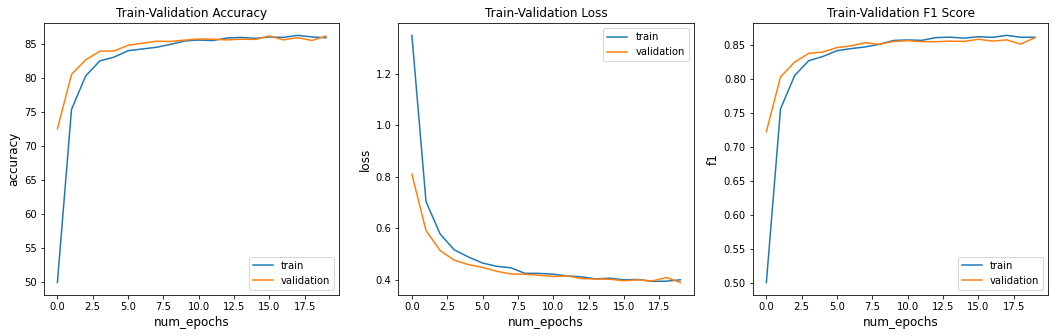

In [20]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Train-Validation Accuracy")
plt.plot(train_accs_new, label='train')
plt.plot(val_accs_new, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.title("Train-Validation Loss")
plt.plot(train_losses_new, label='train')
plt.plot(val_losses_new, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

plt.subplot(1, 3, 3)
plt.title("Train-Validation F1 Score")
plt.plot(train_f1s_new, label='train')
plt.plot(val_f1s_new, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('f1', fontsize=12)
plt.legend(loc='best')

plt.show()

In [ ]:
b = {"val_losses_new": val_losses_new,
"val_accs_new": val_accs_new,
"val_f1s_new": val_f1s_new,
"train_losses_new": train_losses_new,
"train_accs_new": train_accs_new,
"train_f1s_new": train_f1s_new}
print(b)